<a href="https://colab.research.google.com/github/johnsocf/CSCI_3202_HW_5/blob/master/test_hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

In [2]:
!pip install scikit-plot

In [56]:
import os, sys
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import math
import cv2 as cv
import matplotlib.patches as patches
import statistics
import json
import glob
import scikitplot as skplt

#sci kit learn packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split

# keras packages
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers.experimental.preprocessing import CenterCrop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.initializers import he_normal
from keras.layers import (BatchNormalization, Conv2D, Dense, Dropout, Flatten,
                          MaxPool2D, ReLU)
from keras.optimizers import Adam


# additional packages
from google.colab import files
from time import time
from PIL import Image
from operator import itemgetter
from matplotlib.pyplot import imread
from glob import glob




# Import Competition Data from Kaggle

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install kaggle
!pip install --upgrade kaggle

In [43]:
%%capture
!pip install --upgrade --force-reinstall --no-deps kaggle

In [5]:
!mkdir .kaggle

In [6]:
!mkdir .kaggle
!ls -a

mkdir: cannot create directory ‘.kaggle’: File exists
.  ..  .config	.kaggle  sample_data


In [7]:
token = {"username":"catnippsunn","key":"d10a25e54993332212ca4e9f6a8dece2"}


In [13]:
!mkdir .kaggle
!ls -a

mkdir: cannot create directory ‘.kaggle’: File exists
.  ..  .config	.kaggle  sample_data


In [44]:
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [45]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [46]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [47]:
!chmod 600 /root/.kaggle/kaggle.json

In [54]:
import glob
files = glob.glob('/content/*')
for f in files:
    print('f: ', f)
    if os.path.isfile(f):
        os.remove(f)

f:  /content/drive
f:  /content/sample_data


In [55]:
!kaggle competitions download -c histopathologic-cancer-detection -p /content

100% 6.30G/6.31G [02:18<00:00, 46.8MB/s]
100% 6.31G/6.31G [02:19<00:00, 48.7MB/s]


In [57]:
%%capture
!unzip \*.zip

In [58]:
# set useful paths to image and label directories for succinct use in the notebook
model_path = '.'
path = '/content/'
train_folder = '{}train'.format(path)
test_folder = '{}train'.format(path)
train_folder_cr = '{}train_cropped'.format(path)
test_folder_cr = '{}train_cropped'.format(path)
train_label = '{}train_labels.csv'.format(path)
sample_submission = '{}sample_submission.csv'.format(path)
input_test = '{}test'.format(path)

Set up variables based on defaults for data directory paths and shapes.  This allows for easy configuration in the model building fitting. 

In [109]:
directory_for_training = train_folder
data_shape = (96, 96, 3)
dims = (data_shape[0], data_shape[1])
dims

(96, 96)

In [60]:
label_data_df = pd.read_csv(train_label)
label_data_df["file_name"] = label_data_df["id"].apply(lambda x: x + ".tif")

sample_size = 80000
id_label_pos = label_data_df.loc[label_data_df["label"] == 1, :].sample(n=sample_size)
id_label_neg = label_data_df.loc[label_data_df["label"] == 0, :].sample(n=sample_size)
id_label = pd.concat([id_label_pos, id_label_neg], ignore_index=True)
del id_label_pos, id_label_neg

id_label_train, id_label_val = train_test_split(id_label, test_size=0.1, stratify=id_label["label"])
id_label_train.reset_index(drop=True, inplace=True)
id_label_val.reset_index(drop=True, inplace=True)
len_train = id_label_train.shape[0]
len_val = id_label_val.shape[0]
print("Training data size: {}.".format(len_train))
print("Validation data size: {}.".format(len_val))
del id_label

Training data size: 144000.
Validation data size: 16000.


## Labels Dataframe Preprocessing

The Binary Class Mode in Keras preprocessing requires classes to be Strings.  This necessitates a translation from the stored data set which has classes stored as 0 and 1 format to represent negative and positive images, respectively.
Ref: https://keras.io/api/preprocessing/image/

The image ID in the label data set needs to also be adjusted to include the file extension since the mapping of ID will be used directly look up the image in the training and verification directories subsequent steps to set up the CNN.

In [61]:
# update labels since `class_mode='binary' requires classes to be strings.
id_label_train['label'] = np.where(id_label_train['label'] == 0, 'neg','pos')
id_label_val['label'] = np.where(id_label_val['label'] == 0, 'neg','pos')
# update image IDs to include the .tif file format for proper processing in
# subsequent steps.
id_label_train['id'] = id_label_train['id'] + '.tif'
id_label_val['id'] = id_label_val['id'] + '.tif'

In [62]:
id_label_val

,id,label,file_name
0,ff4762d2b984b754f5542f5649f988e9dbbe7164.tif,pos,ff4762d2b984b754f5542f5649f988e9dbbe7164.tif
1,e5c02c781afb181e9e890ce886fdb10348934a75.tif,pos,e5c02c781afb181e9e890ce886fdb10348934a75.tif
2,0b9321022cf7f92fdd6b45ef00b537fed9eace2d.tif,neg,0b9321022cf7f92fdd6b45ef00b537fed9eace2d.tif
3,5e8b638380a25b5d48658f32b25bad069ad35ad3.tif,pos,5e8b638380a25b5d48658f32b25bad069ad35ad3.tif
4,2ab9afcd4e94d485cdba536a5d7d29b60aecdcc5.tif,neg,2ab9afcd4e94d485cdba536a5d7d29b60aecdcc5.tif
...,...,...,...
15995,6b3c57b3b05da35ce58a0508b48b262199c9875f.tif,neg,6b3c57b3b05da35ce58a0508b48b262199c9875f.tif
15996,12ff29afe3c056e32df58d29181893c74ea1f699.tif,pos,12ff29afe3c056e32df58d29181893c74ea1f699.tif
15997,a5c0568834f78b98ef521844915f365ba517ce08.tif,neg,a5c0568834f78b98ef521844915f365ba517ce08.tif
15998,da3868352a777baf8eeaad87883e6ccf6b593320.tif,neg,da3868352a777baf8eeaad87883e6ccf6b593320.tif


In [63]:
train_folder

'/content/train'

In [114]:
img_gen_params = {
    "rescale": 1.0 / 255,
    "samplewise_center": True,
    "samplewise_std_normalization": True,
    "horizontal_flip": True,
    "vertical_flip": True
}

img_gen = ImageDataGenerator(**img_gen_params)

IMAGE_SHAPE = (96, 96, 3)
batch_size = 32

img_flow_params_train = {
    "dataframe": id_label_train,
    "directory": train_folder,
    "x_col": "id",
    "y_col": "label",
    "batch_size": batch_size,
    "target_size": IMAGE_SHAPE[:2],
}

img_flow_train = img_gen.flow_from_dataframe(**img_flow_params_train)

img_flow_params_val = {
    "dataframe": id_label_val,
    "directory": train_folder,
    "x_col": "id",
    "y_col": "label",
    "batch_size": 1,
    "shuffle": False,
    "target_size": IMAGE_SHAPE[:2],
}

img_flow_val = img_gen.flow_from_dataframe(**img_flow_params_val)


model = keras.models.Sequential()

model.add(Conv2D(filters[0], kernel_size, padding="same", kernel_initializer=he_normal(), input_shape=IMAGE_SHAPE))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(filters[0], kernel_size, padding="same", kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D())
model.add(Dropout(drop_prob_conv))

model.add(Conv2D(filters[1], kernel_size, padding="same", kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(filters[1], kernel_size, padding="same", kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D())
model.add(Dropout(drop_prob_conv))

model.add(Conv2D(filters[2], kernel_size, padding="same", kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(filters[2], kernel_size, padding="same", kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D())
model.add(Dropout(drop_prob_conv))

model.add(Flatten())
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(drop_prob_dense))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(drop_prob_dense))
model.add(Dense(2, activation="softmax"))
model.compile(Adam(0.01), loss="categorical_crossentropy", metrics=["accuracy"])


Found 144000 validated image filenames belonging to 2 classes.
Found 16000 validated image filenames belonging to 2 classes.


In [115]:

lr_decay_params = {
    "monitor": "val_acc",
    "factor": 0.5,
    "patience": 1,
    "min_lr": 1e-5
}
lr_decay = ReduceLROnPlateau(**lr_decay_params)

early_stopping = EarlyStopping(monitor="val_acc", patience=3, verbose=1)


# TODO (find additional reference for this setup.)
STEP_SIZE_TRAINING=img_flow_train.n//img_flow_train.batch_size
# Total number of images in the data set / batch size 
# (batch size is set in preprocessing api above).
STEP_SIZE_TESTING=img_flow_train.n//img_flow_train.batch_size

fit_params = {
    "generator": img_flow_train,
    "steps_per_epoch": STEP_SIZE_TRAINING,
    "epochs": 10,
    "verbose": 1,
    "validation_data": img_flow_val,
    "validation_steps": STEP_SIZE_TESTING,
    #"callbacks": [lr_decay, early_stopping]
}
print("Training the model...")
model.fit_generator(**fit_params)
print("Done!")


Training the model...
Epoch 1/10
 131/4500 [..............................] - ETA: 5:26 - loss: 0.6664 - accuracy: 0.7078

KeyboardInterrupt: ignored

ref on, 'fit or fit_generator':  https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/

## Metric Analysis Data Viz on Performance

Display the Confusion Matrix and Classification Reports for the model.

In [118]:
test_steps_per_epoch = np.math.ceil(img_flow_val.samples / img_flow_val.batch_size)

predictions = model.predict_generator(img_flow_val, steps=test_steps_per_epoch)


Instructions for updating:
Please use Model.predict, which supports generators.


In [120]:
# predicted_classes = np.argmax(predictions, axis=1)
# true_classes = img_flow_val.classes
# class_labels = list(img_flow_val.class_indices.keys())   


In [121]:
def plot_roc_curve(fpr,tpr): 
  plt.plot([0, 1], [0, 1], "k--")
  plt.plot(fpr, tpr, label="ACC={:.4F}, AUC={:.4f}".format(acc_val, auc_val))
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")
  plt.title("ROC curve")
  plt.legend(loc="best")
  plt.show()
  plt.savefig("roc_curve.png")

Validation accuracy: 0.731.
(16000,)
Validation AUC: 0.821.


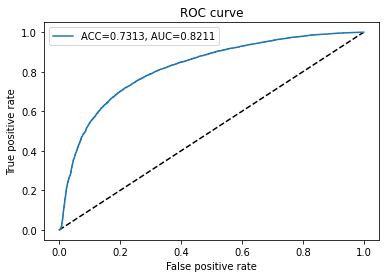

<Figure size 432x288 with 0 Axes>

In [122]:
from sklearn.metrics import auc, roc_curve, confusion_matrix, classification_report
len_val = id_label_val.shape[0]
y_val_pred = model.predict_generator(img_flow_val, steps=test_steps_per_epoch)[:, 1]
y_val_true = img_flow_val.classes
acc_val = np.equal((y_val_pred > 0.5).astype("int"), y_val_true).sum() / y_val_pred.shape[0]
print("Validation accuracy: {:.3f}.".format(acc_val))
print(y_val_pred.shape)

fpr, tpr, thresholds = roc_curve(y_val_true, y_val_pred)
auc_val = auc(fpr, tpr)
print("Validation AUC: {:.3f}.".format(auc_val))

plot_roc_curve(fpr,tpr)



In [ ]:
print(len(y_val_pred))
print(len(y_val_true))
model_orig.summary()

16000
16000
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_157 (Conv2D)          (None, 96, 96, 16)        448       
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 96, 96, 16)        2320      
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 96, 96, 16)        2320      
_________________________________________________________________
dropout_70 (Dropout)         (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 32, 3

In [123]:
print(confusion_matrix(y_val_true, y_val_pred.round()))
report = classification_report(y_val_true, y_val_pred.round(), target_names=class_labels)

from sklearn.metrics import classification_report, roc_curve
print(report) 
print(confusion_matrix(y_val_true, y_val_pred.round()))

[[7030  970]
 [3329 4671]]
              precision    recall  f1-score   support

         neg       0.68      0.88      0.77      8000
         pos       0.83      0.58      0.68      8000

    accuracy                           0.73     16000
   macro avg       0.75      0.73      0.73     16000
weighted avg       0.75      0.73      0.73     16000

[[7030  970]
 [3329 4671]]


## Submission

In [ ]:
test_df = pd.read_csv(sample_submission)

TESTING_BATCH_SIZE = 64
# get test files
testing_files = glob(os.path.join(input_test,'*.tif'))
# create empty pandas dataframe
submission = pd.DataFrame()
print(len(testing_files))
# 10 should be: len(testing_files)
for index in range(0, len(testing_files), TESTING_BATCH_SIZE):
    data_frame = pd.DataFrame({'path': testing_files[index:index+TESTING_BATCH_SIZE]})
    # parse in IDs and Images for each test file item
    data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[3].split(".")[0])
    data_frame['image'] = data_frame['path'].map(imread)
    # join image array
    images = np.stack(data_frame.image, axis=0)
    ids = np.stack(data_frame.id, axis=0)
    # expand dims restructures shape for the image in precitions by expanding it.
    predicted_labels = [model_orig.predict(np.expand_dims(image/255.0, axis=0))[0][0] for image in images]
    # make a prediction array
    predictions = np.array(predicted_labels)
    # assign predictions to a new label column in the df
    data_frame['label'] = predictions
    # can remove this for actual submission, this is more for metric data vis.
    # add frame to existing submission df
    submission = pd.concat([submission, data_frame[["id", "label"]]])
    # mark the passing of time with a log
    if index % 1000 == 0 :
        print(index/len(testing_files) * 100)
# convert the submission to a csv
submission.to_csv('submission_aug_v1.csv', index=False, header=True)
print(submission.head())

In [ ]:
!cp submission_aug_v1.csv "drive/My Drive/"

In [ ]:
# modularize the submission code.
# get prediction labels from df.
# get classes.
# pass to metric data vis module.

refs: 
https://androidkt.com/get-the-roc-curve-and-auc-for-keras-model/

https://tduan.netlify.app/post/ai-from-the-data-center-to-the-edge-training-by-intel/part3-model_analysis

# Are under the ROC curve.

In [ ]:
# max: 0.9179 on non cropped images.
# .86/ 20 epoch with cropped images and standard.
# .599/ 20 cropped and nonstandard.

In [ ]:
# metrics:  https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226
# accuracy, precision, recall.
# f1, log loss (specific for binary classification), auc

# howto?  calc myself or use classificationReport from scikit
# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
# https://keras.io/api/metrics/accuracy_metrics/#binaryaccuracy-class